# COMP3330 - Individual Assignment - Nathan Vilmen

## Question 1: Variation of the Two-Spiral Task

### Subquestion b)

Here we generate and save a different spiral, using some code procided in GitHub.

In [13]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi
# import matplotlib.pyplot as plt

N = 400
theta = np.sqrt(np.random.rand(N))*2*pi # np.linspace(0,2*pi,100)

r_a = 2*theta + pi
data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
x_a = data_a + np.random.randn(N,2)

r_b = -2*theta - pi
data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
x_b = data_b + np.random.randn(N,2)

res_a = np.append(x_a, np.zeros((N,1)), axis=1)
res_b = np.append(x_b, np.ones((N,1)), axis=1)

res = np.append(res_a, res_b, axis=0)
np.random.shuffle(res)

np.savetxt("result.csv", res, delimiter=",", header="", comments="", fmt='%.5f')
#plt.scatter(x_a[:,0],x_a[:,1])
#plt.scatter(x_b[:,0],x_b[:,1])
#plt.show()

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using: {}.'.format(device))

Using: cpu.


In [10]:
import pandas

# file path
csv_file = 'result.csv'

# read the file and create the points
data = pandas.read_csv(csv_file, header=None, names=['x1','x2','y'])

# preview of the data
print(data.head(10))

# create the points' coordinates by splitting into numpy arrays with features and labels
X = data[['x1', 'x2']].to_numpy()
Y = data[['y']].to_numpy().flatten()

# verify the shape of the data : expected to have 194 rows
print(X.shape)
print(Y.shape)

         x1        x2    y
0  -0.01139  11.05902  1.0
1   8.14971 -10.83957  0.0
2   8.77509 -11.73989  0.0
3  -8.46620   2.93680  0.0
4  17.01547   0.15631  0.0
5  12.27866  -6.54662  0.0
6  -0.48668  13.28753  1.0
7   5.02742  11.48607  1.0
8   0.39283 -13.32111  0.0
9  11.24750  -6.99375  0.0
(800, 2)
(800,)


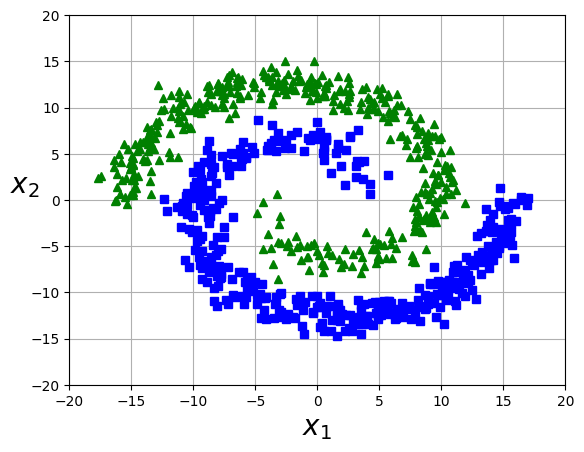

In [12]:
def plot_dataset(X, y, axes):
    """Plot a dataset with two features and binary classes"""
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

# we know from the preview in the sheet that the x-range is approximately -7 to 7
axes = [-20, 20, -20, 20]
plot_dataset(X, Y, axes)

In [15]:
# Input data
x = torch.tensor(X, dtype=torch.float32, device=device)
# check for consistency: x must have 2 columns with 194 rows
print(x.shape)

# Label data
y = torch.tensor(Y, dtype=torch.float32, device=device).view(800,1)
# check for consistency: y must have 1 column with 194 rows
print(y.shape)

torch.Size([800, 2])
torch.Size([800, 1])


In [16]:
class ANN(torch.nn.Module):
    # Here we define the layers of this network.
    def __init__(self):
        super().__init__()
        # Hidden layer which takes 2 bits as inputs and has 8 units
        self.hidden = torch.nn.Linear(2, 8, bias=True)
        # Second hidden layer which takes 8 bits as inputs and has 6 units
        self.hidden_2 = torch.nn.Linear(8, 6, bias=True)
        # Output layer with 8 inputs and 1 output
        self.output = torch.nn.Linear(6, 1, bias=True)
    # Implement the forward pass
    def forward(self, x):
        # apply the hidden layers
        out = torch.nn.Tanh()(self.hidden(x))
        out = torch.nn.Tanh()(self.hidden_2(out))
        # compute the output
        out = torch.nn.Tanh()(self.output(out))
        return out

In [17]:
# Define the Model
model = ANN().to(device)

# Define the loss function
def loss_fn(y_true, y_pred):
    loss = torch.sqrt(torch.mean(torch.pow(y_true - y_pred, 2)))
    return loss

# Define the optimiser and tell it what parameters to update
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
MAX_EPOCHS = 30000 # One epoch means going through entire dataset once
LOSS_GOAL = 0.1
epoch = 0 # Initialise counter
losses = [] # Loss history
best_loss = float("inf") # Keep track of best loss for early stopping
while LOSS_GOAL < best_loss and MAX_EPOCHS > epoch:
    # Reset the gradients for all variables
    optimiser.zero_grad()
    # Forward pass: Calculate prediction
    y_pred = model(x)
    # Calculate loss
    loss = loss_fn(y, y_pred)
    # Backward pass: Run backpropagation
    loss.backward()
    # Adjust weights
    optimiser.step()
    # Save latest loss
    losses.append(loss.item())
    if loss < best_loss:
        best_loss = loss
    if epoch % 1000 == 0:
        print("Loss in epoch {}: {:.4f}".format(epoch, loss))
    epoch += 1

Loss in epoch 0: 0.5402
Loss in epoch 1000: 0.2388
Loss in epoch 2000: 0.1103


In [20]:
y_pred_final = model(x)
loss_final = loss_fn(y_pred_final, y)
# display the final prediction
print("Loss for final weights: {:.4f}".format(loss_final))

Loss for final weights: 0.1000


Accuracy: 100.00%


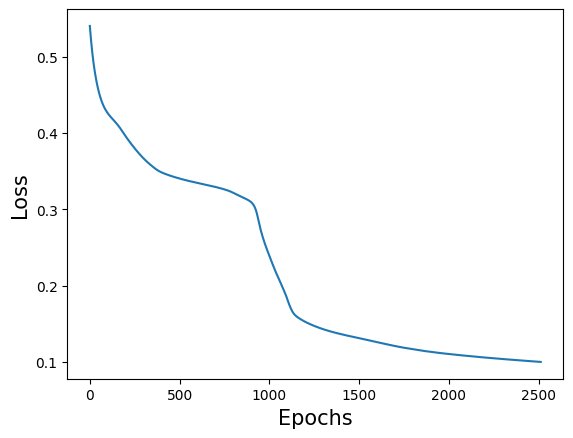

In [21]:
accuracy = torch.sum(torch.round(y_pred_final) == y) / len(y) * 100
print("Accuracy: {:.2f}%".format(accuracy))
plt.plot(losses)
plt.xlabel(r"Epochs", fontsize=15)
plt.ylabel(r"Loss", fontsize=15)
plt.show()

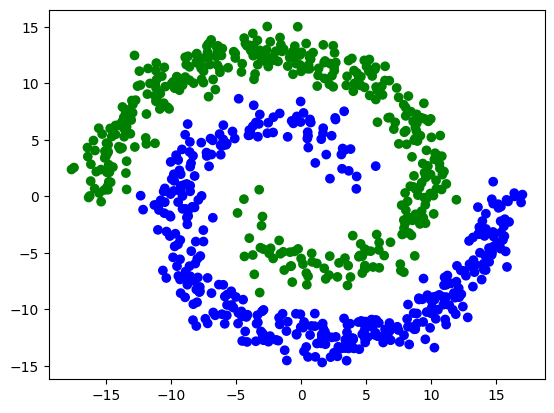

In [22]:
# Color the points based on the values in the y matrix
colors = ['b' if label <= 0.5 else 'g' for label in y_pred_final]
# Plot the points
plt.scatter(x[:, 0], x[:, 1], c=colors)
plt.show()

In [40]:
from sklearn.svm import SVC
svm = SVC(C=10, kernel='rbf', gamma=30)
svm.fit(X, Y)

SVC(C=10, gamma=30)

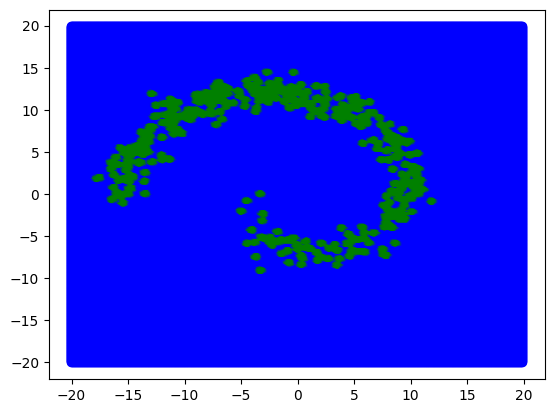

In [41]:
# Visualise activations
activation_range = np.arange(-20, 20, 0.1) # interval of [-20, 20] with step size 0.1
test_coordinates = [(x,y) for y in activation_range for x in activation_range]
test_classifications = svm.predict(test_coordinates)
x_, y_ = np.meshgrid(activation_range, activation_range)
plt.scatter(x_, y_, c=['g' if x_ > 0 else 'b' for x_ in test_classifications])
plt.show()